In [1]:
# !pip3 install --upgrade torch --user
# !pip3 install torchvision --user

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import pickle
import tqdm

import torch
import torch.nn.functional as F
import torch.nn as nn

from torch.nn.parameter import Parameter
import math
from torch.nn.modules.utils import _pair




from torchvision import datasets
from torchvision import transforms

from utils.model_utils import PatchLoader, NonLocalAggregation
from utils.martemev_utils import compute_psnr, get_freer_gpu, get_closest_diff

from time import time

In [49]:
BATCH_SIZE = 1
NUM_WORKERS = 8

GPU_NUM = 0

K_CLOSEST = 8
HIDDEN_SIZE = 16
PATCH_SIZE = (70, 70)

MODEL_NAME = 'Conv.v1.conv.onlystd005'

In [53]:
class PatchLoader(torch.utils.data.Dataset):
    def __init__(self, clear_data, noised_data):
        self.clear_data = [i for i in torch.load(clear_data) if i.std() < 0.05] 
        self.noised_data = [i for i in torch.load(noised_data) if i.std() < 0.05]
 
    def __len__(self):
        return len(self.noised_data)
    def __getitem__(self, index):
        return self.clear_data[index], self.noised_data[index]


In [54]:
train_dataloader = torch.utils.data.DataLoader(
    PatchLoader('../Data/train/clear/normalized_data.tensor',
                '../Data/train/noised/normalized_data.tensor'), 
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=False)

val_dataloader = torch.utils.data.DataLoader(
    PatchLoader('../Data/val/clear/normalized_data.tensor',
                '../Data/val/noised/normalized_data.tensor'), 
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=False)


In [6]:
gpu_num = get_freer_gpu()
device = torch.device('cuda:{}'.format(GPU_NUM))
device

device(type='cuda', index=0)

In [7]:
class LambdaLayer(nn.Module):
    "An easy way to create a pytorch layer for a simple `func`."
    def __init__(self, func):
        "create a layer that simply calls `func` with `x`"
        super().__init__()
        self.func=func

    def forward(self, x):
        return self.func(x)

In [8]:
model = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=(35, 35), stride=5, padding=(35//2, 35//2)),
    nn.BatchNorm2d(16),
    nn.LeakyReLU(0.05),
    nn.Conv2d(16, 32, kernel_size=(15, 15), stride=5, padding=(15//2, 15//2)),
    nn.BatchNorm2d(32),
    nn.LeakyReLU(0.05),
    nn.Conv2d(32, 32, kernel_size=(5, 5), stride=3, padding=(5//2, 5//2)),
    nn.BatchNorm2d(32),
    nn.LeakyReLU(0.05),
    nn.ConvTranspose2d(32, 32, kernel_size=(5, 5), stride=3, padding=(5//3, 5//3)),
    nn.BatchNorm2d(32),
    nn.LeakyReLU(0.05),
    nn.ConvTranspose2d(32, 16, kernel_size=(15, 15), stride=5, padding=(15//3, 15//3)),
    nn.BatchNorm2d(16),
    nn.LeakyReLU(0.05),
    nn.ConvTranspose2d(16, 1, kernel_size=(35, 35), stride=5, padding=(35//2, 35//2)),
).cuda(device)


optim = torch.optim.Adam(model.parameters())
scheduler = torch.optim.lr_scheduler.LambdaLR(optim, lambda x: 0.97**x)

In [9]:
input = next(iter(train_dataloader))

In [10]:
input[1].shape

torch.Size([1, 960, 4492])

In [11]:
%%time

model(input[1].unsqueeze(1).cuda(device)).shape

CPU times: user 12.9 ms, sys: 33.9 ms, total: 46.8 ms
Wall time: 43.3 ms


torch.Size([1, 1, 971, 4496])

In [12]:
# Wall time: 1min 15s
# Wall time: 24.1 ms

In [13]:
from tensorboardX import SummaryWriter
import torchvision.utils as vutils


writer = SummaryWriter('./TensorBoard/{}'.format(MODEL_NAME))

In [14]:
val_images_clear =  torch.load('../Data/val/clear/normalized_data.tensor')
val_images_noised =  torch.load('../Data/val/noised/normalized_data.tensor')

In [15]:
for epoch in tqdm.tqdm_notebook(range(100)):
    for train_ind, (image, noise_image) in enumerate(tqdm.tqdm_notebook(train_dataloader, desc='Train loop', leave=False)):
        model.train()
        ind = epoch * len(train_dataloader) + train_ind
        optim.zero_grad()
        image, noise_image = image.cuda(device).unsqueeze(1), noise_image.cuda(device).unsqueeze(1)
        start_time = time()
        denoised_diff = model(noise_image)[..., :960, :4492]
        end_time = time() - start_time
        writer.add_scalar('train/iteration_time', end_time, ind)
        denoise_image = denoised_diff + noise_image
        max_signals = torch.max(image.view(image.shape[0], -1), dim=1)[0]
        weighted_mse = torch.mean(max_signals * torch.mean(((image - denoise_image)**2).view(image.shape[0], -1), dim=(1)))
        loss = weighted_mse
        writer.add_scalar('train/weighted_mse_loss', loss.item(), ind)
        writer.add_scalar('train/plain_mse_loss', nn.MSELoss()(image, denoise_image).item(), ind)
        loss = loss
        loss.backward()
        optim.step()
        writer.add_scalar('train/psnr', compute_psnr(image, denoise_image), ind)
    scheduler.step()
    model.eval()
    losses, psnrs = [], []
    for val_ind, (image, noise_image) in enumerate(tqdm.tqdm_notebook(val_dataloader, desc='Test loop', leave=False)):
        image, noise_image = image.cuda(device).unsqueeze(1), noise_image.cuda(device).unsqueeze(1)
        denoised_diff = model(noise_image)[..., :960, :4492]
        denoise_image = denoised_diff + noise_image
        max_signals = torch.max(image.view(image.shape[0], -1), dim=1)[0]
        weighted_mse = torch.mean(max_signals * torch.mean(((image - denoise_image)**2).view(image.shape[0], -1), dim=(1)))
        loss = weighted_mse
        losses.append(loss.item())
        psnrs.append(compute_psnr(image, denoise_image))
    writer.add_scalar('val/psnr', np.mean(psnrs), ind)
    writer.add_scalar('val/combined_loss', np.mean(losses), ind)
    img_indexes = torch.randint(high=len(noise_image), size=(1,))
    dummy_img = torch.cat([image[img_indexes],
                           noise_image[img_indexes],
                           denoise_image[img_indexes]], dim=0).cpu().data
    x = vutils.make_grid(dummy_img, nrow=1)
    writer.add_image('val/crops', x, ind)

#     img_index = torch.randint(high=len(val_images_clear), size=(1,))
#     clear_image = val_images_clear[img_index]
#     noised_image = val_images_noised[img_index]
#     start_time = time()
#     denoised_image = model.forward_image(noised_image.squeeze(0), device).cpu().data.unsqueeze(0)
#     end_time = time() - start_time
#     writer.add_scalar('val/full_image_time', end_time, ind)
#     d_x, d_y = denoised_image.shape[-2:]
#     writer.add_image('val/clear_image', clear_image[:, :d_x, :d_y], ind)
#     writer.add_image('val/noised_image', noised_image[:, :d_x, :d_y], ind)
#     writer.add_image('val/denoised_image', denoised_image[:, :d_x, :d_y], ind)            
            
            

In [56]:
torch.save(model, 'SavedModels/{}.model'.format(MODEL_NAME))
torch.save(model.state_dict(), 'SavedModels/{}.state_dict'.format(MODEL_NAME))


In [21]:
clears = []
denoised = []
noises = []

for val_ind, (image, noise_image) in enumerate(tqdm.tqdm_notebook(val_dataloader, desc='Test loop', leave=False)):
    image, noise_image = image.cuda(device).unsqueeze(1), noise_image.cuda(device).unsqueeze(1)
    denoised_diff = model(noise_image)[..., :960, :4492]
    denoise_image = denoised_diff + noise_image
    clears.append(image.cpu().data)
    denoised.append(denoise_image.cpu().data)
    noises.append(noise_image.cpu().data)
    if val_ind > 10:
        break

In [27]:
image.shape

torch.Size([1, 960, 4492])

In [33]:
plt.clf()

<Figure size 432x288 with 0 Axes>

In [44]:
a = iter(train_dataloader)

In [45]:
b = next(a)

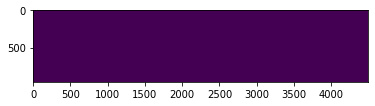

In [46]:
plt.imshow(b[0][0])

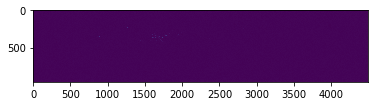

In [47]:
plt.imshow(b[1][0])

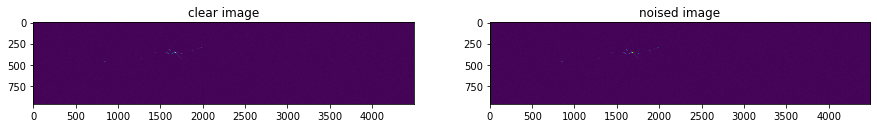

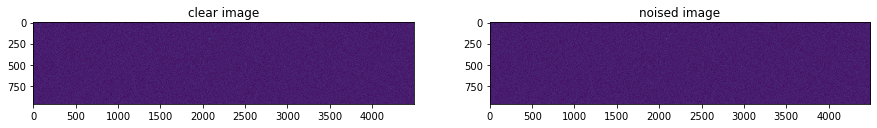

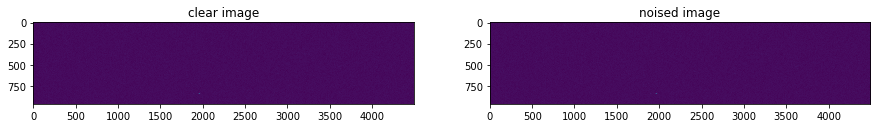

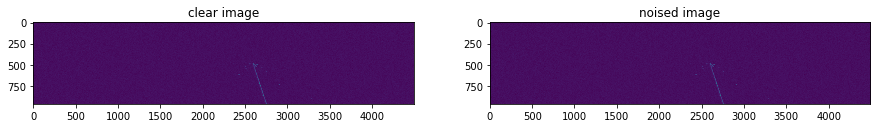

KeyboardInterrupt: 

In [55]:
for val_ind, (image, noise_image) in enumerate(tqdm.tqdm_notebook(train_dataloader, desc='Test loop', leave=False)):
    plt.figure(figsize=(15, 15))
    plt.subplot(1, 2, 1)
    plt.imshow(image[0])
    plt.title('clear image')
    plt.subplot(1, 2, 2)
    plt.imshow(noise_image[0])
    plt.title('noised image')
    plt.show()


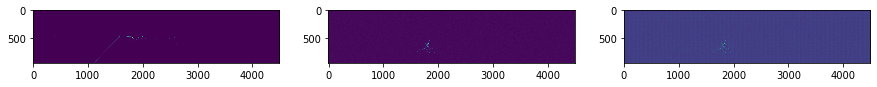

tensor(0.0073) tensor(0.0116) tensor(0.0105)


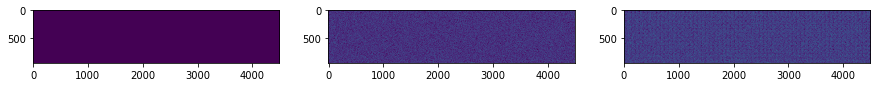

tensor(0.0018) tensor(0.0368) tensor(0.0297)


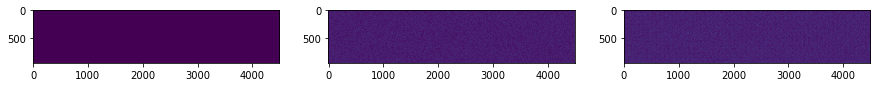

tensor(0.0015) tensor(0.0173) tensor(0.0161)


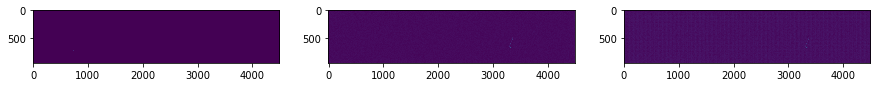

tensor(0.0016) tensor(0.0095) tensor(0.0066)


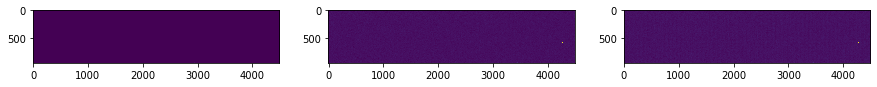

tensor(0.0017) tensor(0.0091) tensor(0.0086)


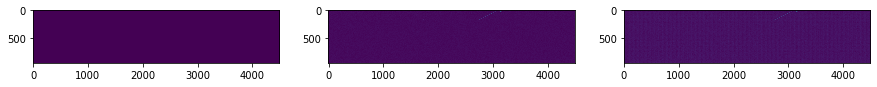

tensor(0.0024) tensor(0.0095) tensor(0.0066)


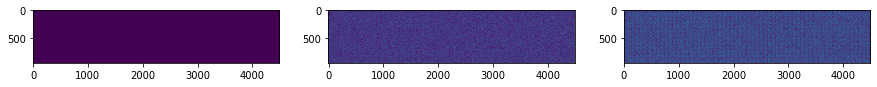

tensor(0.0012) tensor(0.0427) tensor(0.0336)


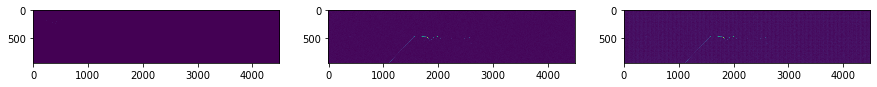

tensor(0.0018) tensor(0.0116) tensor(0.0086)


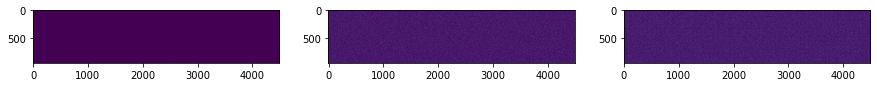

tensor(0.0019) tensor(0.0150) tensor(0.0142)


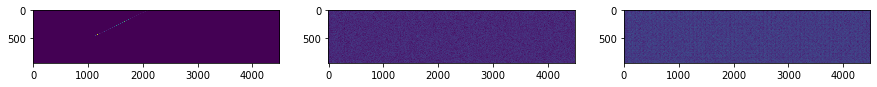

tensor(0.0101) tensor(0.0288) tensor(0.0243)


In [22]:
for i in range(10):
    plt.figure(figsize=(15, 15))
    clear = clears[i][0][0]
    denois = denoised[i][0][0]
    noise = noises[i][0][0]
    plt.subplot(1, 3, 1)
    plt.imshow(clear)
    plt.subplot(1, 3, 2)
    plt.imshow(noise)
    plt.subplot(1, 3, 3)
    plt.imshow(denois)
    plt.show()
    
    print(clear.std(), denois.std(), noise.std())

In [ ]:
clear = clears[3][0][0]
noise = noises[3][0][0]
denoise_image = noises[3][0][0]

for i in range(10):
    plt.figure(figsize=(15, 15))
    

    noise_image = denoise_image.cuda(device).unsqueeze(0).unsqueeze(0)
    denoised_diff = model(noise_image)[..., :960, :4492]
    denoise_image = denoised_diff + noise_image
    denoise_image = denoise_image.cpu().data.squeeze()

    
    plt.subplot(1, 2, 1)
    plt.imshow(clear)
    plt.subplot(1, 2, 2)
    plt.imshow(denoise_image)
    print(denoise_image.max())
#     plt.subplot(1, 3, 3)
#     plt.imshow(noise)
    plt.show()

In [ ]:
noises.cuda(device).unsqueeze(1).shape

In [ ]:
noise.min()